In [2]:
import math
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from typing import Dict, Tuple

In [8]:
def validate_weights(weights:Dict[str, float]) -> Dict[str, float]:
    if not weights:
        raise ValueError("Weights Data is Empty")
    if any(w<0 for w in weights.values()):
        raise ValueError("All weights must be non-negative")
    s= sum(weights.values())
    if s<=0:
        raise ValueError("All weights must be non-negative")

    return {k:(v/s) for k,v in weights.items()}

In [9]:
def fetch_prices(tickers, period="1y", interval="1d") -> pd.DataFrame:
    # yfinance returns multiindex columns sometimes; we coerce to a clean Close frame
    df = yf.download(tickers, period=period, interval=interval, auto_adjust=True, progress=False)
    if df.empty:
        raise SystemExit("No data returned—check tickers/period/internet.")
    # If MultiIndex, pick 'Close' level; else assume it already is Close
    if isinstance(df.columns, pd.MultiIndex):
        if ("Close" in df.columns.get_level_values(0)):
            px = df["Close"].copy()
        else:
            # Fallback to any price-like field
            for lvl0 in ("Adj Close", "Close"):
                if lvl0 in df.columns.get_level_values(0):
                    px = df[lvl0].copy()
                    break
            else:
                raise SystemExit(f"Could not find Close/Adj Close in columns: {df.columns}")
    else:
        # Single index columns (e.g., ['Open','High','Low','Close','Volume'])
        if "Close" in df.columns:
            px = df["Close"].to_frame()
        elif "Adj Close" in df.columns:
            px = df["Adj Close"].to_frame()
        else:
            raise SystemExit(f"No Close/Adj Close columns found: {list(df.columns)}")

    # If single ticker, ensure 2D with that ticker as column name
    if isinstance(px, pd.Series):
        px = px.to_frame(name=tickers if isinstance(tickers, str) else list(weights.keys())[0])
    px = px.dropna(how="all")
    return px


In [10]:
def last_prices(price_df: pd.DataFrame) -> Dict[str, float]:
    last_row = price_df.dropna().iloc[-1]
    return {sym: float(last_row[sym]) for sym in last_row.index}

def allocate_shares(weights: Dict[str, float], prices: Dict[str, float], capital: float) -> Tuple[Dict[str, int], float]:
    shares = {}
    spent = 0.0
    for sym, w in weights.items():
        p = prices[sym]
        dollar = w * capital
        q = int(dollar // p)  # integer shares
        shares[sym] = q
        spent += q * p
    cash = capital - spent
    return shares, cash

def portfolio_nav_series(price_df: pd.DataFrame, shares: Dict[str, int], cash: float) -> pd.Series:
    # Align shares dict to columns; missing cols handled by reindex
    cols = price_df.columns.tolist()
    share_vec = pd.Series({c: shares.get(c, 0) for c in cols}, index=cols, dtype=float)
    nav = (price_df * share_vec).sum(axis=1) + cash
    nav.name = "NAV"
    return nav

def current_weights_from_shares(prices: Dict[str, float], shares: Dict[str, int], cash: float) -> Dict[str, float]:
    equity = sum(shares[s] * prices[s] for s in shares)
    total = equity + cash
    if total <= 0:
        raise ValueError("Total portfolio value must be positive.")
    return {s: (shares[s] * prices[s]) / total for s in shares}

def drift_and_rebalance_trades(target_w: Dict[str, float],
                               prices: Dict[str, float],
                               shares: Dict[str, int],
                               cash: float,
                               tolerance: float = 0.02,
                               fee_bps: float = 5.0):
    """
    Returns a trades dict {symbol: delta_shares} to move within tolerance,
    and a summary of costs. Trade sign: +buy, -sell.
    """
    # Compute current weights
    curr_w = current_weights_from_shares(prices, shares, cash)
    total_val = sum(shares[s]*prices[s] for s in shares) + cash

    # Desired dollar per asset
    desired_dollars = {s: target_w[s]*total_val for s in target_w}
    current_dollars = {s: shares[s]*prices[s] for s in shares}

    drift = {s: (current_dollars[s]/total_val) - target_w[s] for s in target_w}
    # If all within tolerance, no trades
    if all(abs(drift[s]) <= tolerance for s in drift):
        return {}, {"within_tolerance": True, "fees_paid": 0.0, "cash_after": cash, "total_val": total_val, "drift": drift}

    # Compute target shares rounded to integers
    target_shares = {s: int(desired_dollars[s] // prices[s]) for s in target_w}
    delta_shares = {s: target_shares[s] - shares[s] for s in target_w}

    # Compute trade cash impact & fees
    notional = sum(abs(delta_shares[s]) * prices[s] for s in delta_shares)
    fees = notional * (fee_bps / 10_000.0)
    cash_after = cash - sum(delta_shares[s]*prices[s] for s in delta_shares) - fees

    # If cash becomes negative (insufficient), scale trades down proportionally (greedy fallback)
    if cash_after < 0:
        scale = max(0.0, (cash - fees) / max(1e-9, sum(max(0, d)*prices[s] for s, d in delta_shares.items())))
        scaled_delta = {}
        cash_spend = 0.0
        for s, d in delta_shares.items():
            if d > 0:
                d2 = int(math.floor(d * scale))
            else:
                d2 = d  # allow full sells
            scaled_delta[s] = d2
            cash_spend += d2 * prices[s]
        notional = sum(abs(scaled_delta[s]) * prices[s] for s in scaled_delta)
        fees = notional * (fee_bps / 10_000.0)
        cash_after = cash - cash_spend - fees
        delta_shares = scaled_delta

    return delta_shares, {
        "within_tolerance": False,
        "fees_paid": fees,
        "cash_after": cash_after,
        "total_val": sum((shares[s]+delta_shares[s])*prices[s] for s in shares) + cash_after,
        "drift": drift
    }

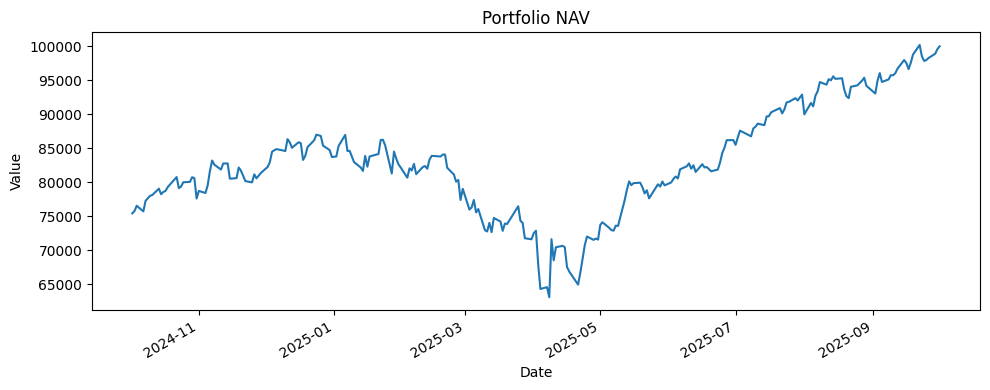

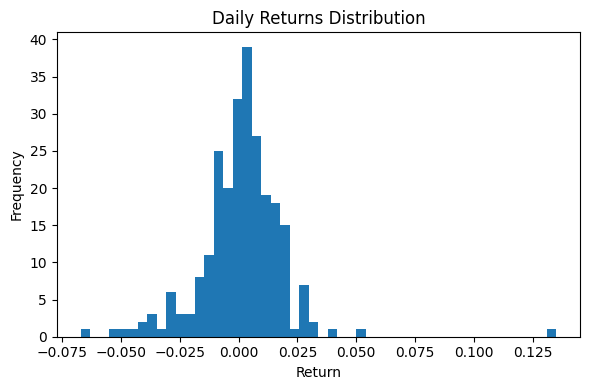


=== Positions ===
       Shares  LastPrice  PositionValue  TargetWeight  CurrentWeight   Drift
AAPL       78     255.45     19925.0998          0.20         0.1993 -0.0007
AMZN       67     220.63     14782.2103          0.15         0.1478 -0.0022
GOOGL      61     244.90     14938.8996          0.15         0.1494 -0.0006
MSFT       38     519.71     19748.9808          0.20         0.1975 -0.0025
NVDA      160     187.24     29958.4009          0.30         0.2996 -0.0004

=== Rebalance Proposal ===
       DeltaShares  TradeNotional
AAPL           NaN            0.0
AMZN           NaN            0.0
GOOGL          NaN            0.0
MSFT           NaN            0.0
NVDA           NaN            0.0

Summary: {'within_tolerance': True, 'fees_paid': 0.0, 'cash_after': 646.4086, 'total_val': 100000.0, 'drift': {'AAPL': -0.0007490023803710943, 'MSFT': -0.002510191650390625, 'NVDA': -0.00041599121093749414, 'GOOGL': -0.0006110037231445153, 'AMZN': -0.0021778967285156214}}

CSV exports:

In [11]:
if __name__ == "__main__":
    # --- Inputs ---
    weights = {"AAPL":0.20, "MSFT":0.20, "NVDA":0.30, "GOOGL":0.15, "AMZN":0.15}
    capital = 100_000
    period = "1y"
    interval = "1d"
    tolerance = 0.02
    fee_bps = 5.0

    # 1) Normalize weights
    weights = validate_weights(weights)

    # 2) Pull prices
    tickers = list(weights.keys())
    px = fetch_prices(tickers, period=period, interval=interval)

    # Ensure the columns match our tickers exactly
    missing = [t for t in tickers if t not in px.columns]
    if missing:
        raise SystemExit(f"Price data missing for: {missing}")

    # 3) Last prices & initial allocation
    lp = last_prices(px)
    shares, cash = allocate_shares(weights, lp, capital)

    # 4) NAV series & returns
    nav = portfolio_nav_series(px, shares, cash)
    ret = nav.pct_change().dropna()
    nav.to_csv("portfolio_nav.csv")
    ret.to_csv("portfolio_returns.csv")

    # 5) Current weights and drift
    curr_w = current_weights_from_shares(lp, shares, cash)
    # 6) Rebalance proposal
    trades, summary = drift_and_rebalance_trades(weights, lp, shares, cash, tolerance, fee_bps)

    # 7) Build reports
    positions = pd.DataFrame({
        "Shares": pd.Series(shares, dtype=int),
        "LastPrice": pd.Series(lp),
        "PositionValue": pd.Series({s: shares[s]*lp[s] for s in shares}),
        "TargetWeight": pd.Series(weights),
        "CurrentWeight": pd.Series(curr_w)
    }).sort_index()
    positions["Drift"] = positions["CurrentWeight"] - positions["TargetWeight"]

    trade_df = pd.DataFrame({
        "DeltaShares": pd.Series(trades, dtype=int),
        "TradeNotional": pd.Series({s: (trades.get(s,0) * lp[s]) for s in weights})
    }).sort_index()

    positions.to_csv("portfolio_positions.csv")
    trade_df.to_csv("portfolio_rebalance_trades.csv")

    # 8) Simple plots
    plt.figure(figsize=(10,4))
    nav.plot()
    plt.title("Portfolio NAV")
    plt.xlabel("Date"); plt.ylabel("Value")
    plt.tight_layout(); plt.show()

    plt.figure(figsize=(6,4))
    ret.plot(kind="hist", bins=50)
    plt.title("Daily Returns Distribution")
    plt.xlabel("Return")
    plt.tight_layout(); plt.show()

    # 9) Print summary
    print("\n=== Positions ===")
    print(positions.round(4))
    print("\n=== Rebalance Proposal ===")
    print(trade_df.round(2))
    print("\nSummary:", {k: (round(v,4) if isinstance(v, float) else v) for k,v in summary.items()})
    print(f"\nCSV exports: portfolio_positions.csv, portfolio_rebalance_trades.csv, portfolio_nav.csv, portfolio_returns.csv")